## This notebook shows how to load the dataset TDvsCPu and then training 3 Nets with evaluations
## For others datasets, just load the other dataset and change the name of dataset.
## All models are trained. So the training process has been commented. You can uncomment it in case of needed.

## Load the dataset and split the data to train, validation, and test sets.

In [1]:
from utils.utils import gait_dataloader
from utils.utils import init_model,  patients_idx_to_cycles_idx, find_cycles_idx_by_patient_idx
from sklearn.model_selection import train_test_split

from utils.utils import init_model,accuracy_end_to_end
import os
import numpy as np

from sklearn.metrics import f1_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix

import seaborn as sn

from utils.utils import *

def load_dataset_v1(dir_dataset,channel_first=True,flatten=True,shuffle=False,random_state=0):
    index = [0,1,2,3,4,5,6,7,8,9,14,15,16,17,18,19,20,21,22,23,24,29]
    
    npzfile = np.load(dir_dataset + 'RightPC.npz')
    
    x_train_all = npzfile['Input']
    y_train = npzfile['Output']
    y_train = np.ravel(y_train)
    x_train = x_train_all[:,:,index]
    if channel_first:
        x_train = x_train.transpose(0,2,1)
    
    npzfile = np.load(dir_dataset + 'LeftPC.npz')
    x_val_all = npzfile['Input']
    y_val = npzfile['Output']
    y_val = np.ravel(y_val)
    x_val = x_val_all[:,:,index]
    if channel_first:
        x_val = x_val.transpose(0,2,1)
    
    npzfile = np.load(dir_dataset + 'TD.npz')
    x_test_all = npzfile['Input']
    y_test = npzfile['Output']
    y_test = np.ravel(y_test)
    x_test = x_test_all[:,:,index]
    if channel_first:
        x_test = x_test.transpose(0,2,1)
    
    if flatten == True:
        x_train = x_train.reshape([x_train.shape[0],-1])
        x_val = x_val.reshape([x_val.shape[0],-1])
        x_test = x_test.reshape([x_test.shape[0],-1])
    
    nb_classes = len(np.unique(np.concatenate((y_train, y_val, y_test), axis=0)))
    
    return x_train, y_train ,x_val, y_val, x_test, y_test, nb_classes

dataset = "archives/AQM/TDvsPC_new_no_shuffle/"

x_R, y_R ,x_L , y_L, x_TD, y_TD, nb_classes = load_dataset_v1(dataset,channel_first=True,flatten=False,shuffle=False,random_state=0)

X_d = np.concatenate([x_R,x_L,x_TD])
# X_d = X_d.reshape([len(X_d),-1])
y_d = np.concatenate([y_R,y_L,y_TD])
import  pandas as pd

# R_data = pd.read_csv('DataPC - Right.csv', header=None)
# R_idx = R_data[2].to_numpy()


CP_data = pd.read_csv('DataCP - all.csv', header=None)
CP_idx = CP_data[1].to_numpy()

TD_data = pd.read_csv('DataTD - By Subject.csv', header=None)
TD_idx = TD_data[1].to_numpy()
TD_idx = TD_idx + CP_idx[-1]

cycle_end_idx = np.concatenate([CP_idx,TD_idx])
cycle_end_idx

patient_index_range = np.arange(len(CP_idx)+len(TD_idx))
patient_class = np.concatenate([np.ones(len(CP_idx)), np.zeros(len(TD_idx))])

x_train, x_test, y_train, y_test = train_test_split(patient_index_range, patient_class, test_size=0.4, stratify=patient_class,random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_test,y_test, test_size=0.75, random_state=0, stratify=y_test)
print(np.unique(y_train,return_counts=True))
print(np.unique(y_val,return_counts=True))
print(np.unique(y_test,return_counts=True))

(array([0., 1.]), array([35, 89]))
(array([0., 1.]), array([ 6, 14]))
(array([0., 1.]), array([18, 45]))


## Print the number of cycles in each set

In [2]:
print("train set")
print("0-",len(patients_idx_to_cycles_idx(x_train[np. where(y_train == 0)],cycle_end_idx)))
print("1-",len(patients_idx_to_cycles_idx(x_train[np. where(y_train == 1)],cycle_end_idx)))
print(len(patients_idx_to_cycles_idx(x_train,cycle_end_idx)))

print("val set")
print("0-",len(patients_idx_to_cycles_idx(x_val[np. where(y_val == 0)],cycle_end_idx)))
print("1-",len(patients_idx_to_cycles_idx(x_val[np. where(y_val == 1)],cycle_end_idx)))
print(len(patients_idx_to_cycles_idx(x_val,cycle_end_idx)))

print("test set")
print("0-",len(patients_idx_to_cycles_idx(x_test[np. where(y_test == 0)],cycle_end_idx)))
print("1-",len(patients_idx_to_cycles_idx(x_test[np. where(y_test == 1)],cycle_end_idx)))
print(len(patients_idx_to_cycles_idx(x_test,cycle_end_idx)))


train set
0- 375
1- 1637
2012
val set
0- 76
1- 279
355
test set
0- 199
1- 813
1012


## Define the function to train and evaluate the model

In [3]:
def train_model(D_name,Net_name):
    a_list = []
    for i in range(10):
        print("train number -", i)
        classifer = init_model(model_name=Net_name,lr_reduce=True, earlystopping=True, lr_patience=1, batch_size=32,lr=0.001, max_epochs=50,default_root_dir="./new_train_lrR_ET_"+D_name+"_"+Net_name+"/",nb_classes=2)
        classifer.fit(X_d[patients_idx_to_cycles_idx(x_train,cycle_end_idx)], y_d[patients_idx_to_cycles_idx(x_train,cycle_end_idx)], X_d[patients_idx_to_cycles_idx(x_val,cycle_end_idx)], y_d[patients_idx_to_cycles_idx(x_val,cycle_end_idx)],ckpt_monitor='val_accuracy')
#         a_list.append(accuracy_score(y_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)], classifer.predict(X_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)])))
        print("train number end -", i)

from sklearn.metrics import f1_score

def eval_model(D_name,Net_name):
    
    list_f1 = []
    list_accuracy = []

    import os
    filePath = "./new_train_lrR_ET_"+D_name+"_"+Net_name+"/"
    os.listdir(filePath)

    for i in os.listdir(filePath):
        if 'model' in i:
            print(i)
            classifer = init_model(model_name=Net_name).load( "./new_train_lrR_ET_"+D_name+"_"+Net_name+"/"+str(i),nb_classes=2)
            list_accuracy.append(accuracy_score(y_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)], classifer.predict(X_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)])))
            list_f1.append(f1_score(y_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)], classifer.predict(X_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)])))
    return list_accuracy, "%.4f" %(np.mean(list_accuracy)) +"±"+ "%.4f" %(np.std(list_accuracy)),list_f1 , "%.4f" %(np.mean(list_f1)) +"±"+ "%.4f" %(np.std(list_f1))

def batch_predict(images,model_path):
    pred_set = Dataset_torch(images,with_label=False)
    data_loader_pred = torch.utils.data.DataLoader(dataset=pred_set, batch_size=64,num_workers=4)
    
    
    classifer = init_model(model_name=Net_name,nb_classes=2).load(model_path)
    
    trainer = pl.Trainer()
    pred = trainer.predict(model=classifer.model,dataloaders = data_loader_pred)
    pred = torch.cat(pred)
    return pred.detach().cpu().numpy()

from torch.utils.data import Dataset
from utils.utils import gait_dataloader
from utils.utils import init_model
## lime
import torch
import pytorch_lightning as pl
class Dataset_torch(Dataset):

    def __init__(self, data,with_label=True):
        self.with_label =  with_label
        
        if self.with_label:
            self.data_x, self.data_y = data
        else:
            self.data_x = data
    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        if self.with_label:
            return self.data_x[idx], self.data_y[idx]
        else:
            return self.data_x[idx]

def eval_model_5_bundle(D_name,Net_name,idx=None):
    
    list_f1 = []
    list_accuracy = []

    import os
    filePath = "./new_train_lrR_ET_"+D_name+"_"+Net_name+"/"
    model_list = os.listdir(filePath)
    model_list.remove('logs')
    if 'prediction.npy' in model_list:
        model_list.remove('prediction.npy')
    proba_sum_list = []
    if idx==None:
        for index in range(10):
            print(index)
            proba_sum = np.zeros([len(y_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)]),2])
            for j in range(5):

                print(model_list[index])
    #             classifer = init_model(model_name=Net_name).load( "./new_train_lrR_ET_"+D_name+"_"+Net_name+"/"+model_list[index*5+j])
                print(batch_predict(X_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)],"./new_train_lrR_ET_"+D_name+"_"+Net_name+"/"+model_list[index*5+j]))
                proba_sum +=batch_predict(X_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)],"./new_train_lrR_ET_"+D_name+"_"+Net_name+"/"+model_list[index*5+j])/5
            proba_sum_list.append(proba_sum)
    else:
            index = idx
            print(index)
            proba_sum = np.zeros([len(y_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)]),3])
            for j in range(5):

                print(model_list[index])
    #             classifer = init_model(model_name=Net_name).load( "./new_train_lrR_ET_"+D_name+"_"+Net_name+"/"+model_list[index*5+j])
                print(batch_predict(X_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)],"./new_train_lrR_ET_"+D_name+"_"+Net_name+"/"+model_list[index*5+j]))
                proba_sum +=batch_predict(X_d[patients_idx_to_cycles_idx(x_test,cycle_end_idx)],"./new_train_lrR_ET_"+D_name+"_"+Net_name+"/"+model_list[index*5+j])/5
            proba_sum_list = (proba_sum)
    return proba_sum_list

## Train and evaluate the model
### To train the model, just uncommented the 
### "     for j in range(5):
###         train_model(D_name=D_name,Net_name=Net_name)"

In [4]:
D_name_add = 'TDvsCPu'
D_name = D_name_add+"_full_5"
Net_name_list = ['ResNet']

for Net_name in Net_name_list:
    # for j in range(5):
    #     train_model(D_name=D_name,Net_name=Net_name)
    out = eval_model_5_bundle(D_name,Net_name)
    np.save( './new_train_lrR_ET_'+D_name+'_'+Net_name+'/prediction.npy' ,out)

0
model-epoch=05-val_loss=1.36-val_accuracy=0.93.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0:  56%|██████████▋        | 9/16 [00:00<00:00, 37.05it/s]

/home/zhengyang/anaconda3/envs/env_gait3/lib/python3.9/site-packages/torch/nn/modules/module.py:1751: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 45.69it/s]
[[2.0680894e-01 7.9319108e-01]
 [3.5086325e-01 6.4913678e-01]
 [5.6300912e-02 9.4369906e-01]
 ...
 [1.2464813e-04 9.9987531e-01]
 [1.3070443e-06 9.9999869e-01]
 [6.6303060e-06 9.9999332e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 53.78it/s]
model-epoch=05-val_loss=1.36-val_accuracy=0.93.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 61.98it/s]
[[2.0490175e-02 9.7950977e-01]
 [4.8857811e-03 9.9511421e-01]
 [1.0275792e-03 9.9897242e-01]
 ...
 [9.3543633e-05 9.9990642e-01]
 [5.1469990e-04 9.9948525e-01]
 [8.7114691e-04 9.9912888e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 65.48it/s]
model-epoch=05-val_loss=1.36-val_accuracy=0.93.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 57.23it/s]
[[5.4226287e-02 9.4577372e-01]
 [2.9784000e-02 9.7021604e-01]
 [1.2232901e-02 9.8776710e-01]
 ...
 [2.7076343e-02 9.7292364e-01]
 [4.2006056e-04 9.9957997e-01]
 [2.4731173e-03 9.9752694e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 60.57it/s]
model-epoch=05-val_loss=1.36-val_accuracy=0.93.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 46.21it/s]
[[5.31411672e-04 9.99468625e-01]
 [1.66095619e-04 9.99833822e-01]
 [1.10592184e-04 9.99889374e-01]
 ...
 [1.20211048e-02 9.87978935e-01]
 [6.96285933e-05 9.99930382e-01]
 [2.03839198e-04 9.99796212e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 57.87it/s]
model-epoch=05-val_loss=1.36-val_accuracy=0.93.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 61.40it/s]
[[1.9205293e-04 9.9980801e-01]
 [4.0651292e-05 9.9995935e-01]
 [1.3165097e-04 9.9986827e-01]
 ...
 [3.4627438e-04 9.9965370e-01]
 [3.1692682e-05 9.9996829e-01]
 [6.6779096e-05 9.9993324e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 55.69it/s]
1
model-epoch=09-val_loss=0.65-val_accuracy=0.90.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 61.62it/s]
[[0.06456264 0.9354373 ]
 [0.03985769 0.9601423 ]
 [0.14851566 0.8514843 ]
 ...
 [0.02718187 0.97281814]
 [0.00912851 0.9908715 ]
 [0.01820064 0.9817994 ]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 56.85it/s]
model-epoch=09-val_loss=0.65-val_accuracy=0.90.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 55.44it/s]
[[2.5726870e-02 9.7427320e-01]
 [8.7338599e-04 9.9912661e-01]
 [5.8425581e-03 9.9415743e-01]
 ...
 [9.2637289e-04 9.9907362e-01]
 [3.6492024e-04 9.9963510e-01]
 [6.5683550e-04 9.9934310e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 33.31it/s]
model-epoch=09-val_loss=0.65-val_accuracy=0.90.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 57.49it/s]
[[0.04664965 0.95335037]
 [0.03832749 0.96167254]
 [0.00931501 0.9906849 ]
 ...
 [0.02035037 0.97964954]
 [0.00518217 0.9948178 ]
 [0.00791119 0.9920888 ]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 58.20it/s]
model-epoch=09-val_loss=0.65-val_accuracy=0.90.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 53.41it/s]
[[1.0777170e-02 9.8922288e-01]
 [2.2087742e-03 9.9779117e-01]
 [2.7305875e-03 9.9726933e-01]
 ...
 [1.1870109e-03 9.9881303e-01]
 [3.8328124e-04 9.9961674e-01]
 [1.1188057e-03 9.9888116e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 58.45it/s]
model-epoch=09-val_loss=0.65-val_accuracy=0.90.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 54.43it/s]
[[2.1417344e-04 9.9978584e-01]
 [2.2733668e-04 9.9977273e-01]
 [3.7624832e-04 9.9962378e-01]
 ...
 [1.9587594e-04 9.9980420e-01]
 [8.6818123e-05 9.9991322e-01]
 [5.5461633e-04 9.9944538e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 58.94it/s]
2
model-epoch=02-val_loss=0.39-val_accuracy=0.88.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 57.11it/s]
[[0.10351106 0.8964889 ]
 [0.03683962 0.9631604 ]
 [0.05224169 0.9477583 ]
 ...
 [0.04810148 0.9518986 ]
 [0.00260852 0.99739146]
 [0.0064606  0.9935394 ]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 57.45it/s]
model-epoch=02-val_loss=0.39-val_accuracy=0.88.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 57.45it/s]
[[5.2307744e-02 9.4769228e-01]
 [3.0394634e-02 9.6960539e-01]
 [5.4319232e-04 9.9945682e-01]
 ...
 [1.6101849e-03 9.9838984e-01]
 [4.0460803e-04 9.9959546e-01]
 [1.1084826e-03 9.9889153e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 63.54it/s]
model-epoch=02-val_loss=0.39-val_accuracy=0.88.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 62.34it/s]
[[9.2188240e-04 9.9907815e-01]
 [8.0678181e-04 9.9919325e-01]
 [7.8907498e-04 9.9921095e-01]
 ...
 [1.1360089e-03 9.9886405e-01]
 [3.0092520e-04 9.9969912e-01]
 [7.0354051e-04 9.9929643e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 57.35it/s]
model-epoch=02-val_loss=0.39-val_accuracy=0.88.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 64.19it/s]
[[0.6615471  0.33845294]
 [0.18444052 0.81555945]
 [0.08619156 0.91380847]
 ...
 [0.04354697 0.9564531 ]
 [0.00644891 0.993551  ]
 [0.02177945 0.9782205 ]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 55.72it/s]
model-epoch=02-val_loss=0.39-val_accuracy=0.88.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 61.13it/s]
[[9.8939337e-02 9.0106064e-01]
 [1.3630616e-02 9.8636937e-01]
 [4.0005804e-03 9.9599946e-01]
 ...
 [1.2586868e-03 9.9874133e-01]
 [8.2126055e-05 9.9991786e-01]
 [2.4388656e-04 9.9975616e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 66.20it/s]
3
model-epoch=02-val_loss=0.96-val_accuracy=0.92.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 62.09it/s]
[[3.0888109e-03 9.9691123e-01]
 [2.0708539e-02 9.7929150e-01]
 [1.6350829e-03 9.9836487e-01]
 ...
 [2.2877334e-02 9.7712266e-01]
 [6.5070676e-04 9.9934930e-01]
 [8.0461325e-03 9.9195391e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 60.98it/s]
model-epoch=02-val_loss=0.96-val_accuracy=0.92.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 62.87it/s]
[[4.4374098e-03 9.9556255e-01]
 [2.2659667e-03 9.9773407e-01]
 [4.4819256e-03 9.9551815e-01]
 ...
 [8.1034028e-04 9.9918967e-01]
 [1.3324242e-03 9.9866760e-01]
 [2.7970991e-03 9.9720287e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 62.50it/s]
model-epoch=02-val_loss=0.96-val_accuracy=0.92.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 64.18it/s]
[[8.5563149e-04 9.9914432e-01]
 [2.2847226e-04 9.9977154e-01]
 [3.3678196e-04 9.9966323e-01]
 ...
 [9.9535706e-04 9.9900466e-01]
 [5.1759603e-04 9.9948239e-01]
 [1.4250170e-03 9.9857497e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 56.71it/s]
model-epoch=02-val_loss=0.96-val_accuracy=0.92.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 64.92it/s]
[[0.01166986 0.9883301 ]
 [0.00421617 0.9957838 ]
 [0.00146935 0.9985306 ]
 ...
 [0.0018661  0.99813396]
 [0.00113563 0.9988644 ]
 [0.00970479 0.9902952 ]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 62.45it/s]
model-epoch=02-val_loss=0.96-val_accuracy=0.92.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 63.84it/s]
[[2.8330961e-04 9.9971670e-01]
 [3.6491486e-04 9.9963510e-01]
 [7.7180550e-05 9.9992287e-01]
 ...
 [3.8912811e-05 9.9996114e-01]
 [9.9843992e-06 9.9998999e-01]
 [1.8372446e-05 9.9998164e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 62.59it/s]
4
model-epoch=04-val_loss=0.99-val_accuracy=0.92.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 64.21it/s]
[[0.12261735 0.87738264]
 [0.24095234 0.7590477 ]
 [0.19296733 0.8070327 ]
 ...
 [0.00176236 0.9982376 ]
 [0.00152322 0.9984768 ]
 [0.00222964 0.9977704 ]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 67.11it/s]
model-epoch=04-val_loss=0.99-val_accuracy=0.92.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 61.79it/s]
[[6.6735386e-04 9.9933261e-01]
 [3.0524418e-04 9.9969482e-01]
 [2.2709100e-04 9.9977297e-01]
 ...
 [1.3839540e-03 9.9861598e-01]
 [1.2284776e-03 9.9877149e-01]
 [5.4044444e-03 9.9459559e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 62.80it/s]
model-epoch=04-val_loss=0.99-val_accuracy=0.92.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 60.29it/s]
[[0.49074486 0.5092551 ]
 [0.0469952  0.9530048 ]
 [0.56014895 0.4398511 ]
 ...
 [0.02366314 0.97633684]
 [0.05385226 0.9461477 ]
 [0.08305649 0.9169435 ]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 61.70it/s]
model-epoch=04-val_loss=0.99-val_accuracy=0.92.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 63.75it/s]
[[0.0608765  0.9391235 ]
 [0.01867443 0.9813255 ]
 [0.03795367 0.9620463 ]
 ...
 [0.00118564 0.99881434]
 [0.00523004 0.99477   ]
 [0.00810013 0.99189985]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 63.60it/s]
model-epoch=04-val_loss=0.99-val_accuracy=0.92.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 64.19it/s]
[[2.0804033e-03 9.9791962e-01]
 [1.3403014e-03 9.9865973e-01]
 [3.7505224e-04 9.9962497e-01]
 ...
 [1.9669662e-04 9.9980336e-01]
 [1.1751021e-05 9.9998820e-01]
 [3.4065335e-05 9.9996591e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 63.61it/s]
5
model-epoch=00-val_loss=0.63-val_accuracy=0.89.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 62.53it/s]
[[2.2599275e-01 7.7400726e-01]
 [2.7957848e-01 7.2042149e-01]
 [9.0349607e-02 9.0965033e-01]
 ...
 [2.4699938e-02 9.7530013e-01]
 [1.6306243e-04 9.9983692e-01]
 [4.2779656e-04 9.9957222e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 61.07it/s]
model-epoch=00-val_loss=0.63-val_accuracy=0.89.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 62.95it/s]
[[0.06940596 0.930594  ]
 [0.04829339 0.95170665]
 [0.03023339 0.96976656]
 ...
 [0.00239541 0.9976046 ]
 [0.00154242 0.99845755]
 [0.00497731 0.99502265]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 59.45it/s]
model-epoch=00-val_loss=0.63-val_accuracy=0.89.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 61.52it/s]
[[8.5255888e-05 9.9991477e-01]
 [1.4331740e-04 9.9985671e-01]
 [2.7846079e-05 9.9997211e-01]
 ...
 [5.7713580e-03 9.9422860e-01]
 [6.7125127e-04 9.9932873e-01]
 [2.7123222e-03 9.9728775e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 66.63it/s]
model-epoch=00-val_loss=0.63-val_accuracy=0.89.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 64.13it/s]
[[0.36854792 0.6314521 ]
 [0.20318367 0.7968163 ]
 [0.3840027  0.6159973 ]
 ...
 [0.16179055 0.83820945]
 [0.10627507 0.893725  ]
 [0.14012235 0.85987765]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 62.65it/s]
model-epoch=00-val_loss=0.63-val_accuracy=0.89.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 59.53it/s]
[[1.5672604e-03 9.9843270e-01]
 [8.1596570e-04 9.9918407e-01]
 [4.1490127e-04 9.9958509e-01]
 ...
 [3.5218103e-03 9.9647826e-01]
 [6.2560989e-04 9.9937445e-01]
 [2.5372780e-03 9.9746275e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 60.08it/s]
6
model-epoch=01-val_loss=0.73-val_accuracy=0.94.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 60.34it/s]
[[2.3504850e-02 9.7649515e-01]
 [5.9580123e-03 9.9404198e-01]
 [6.4410229e-04 9.9935585e-01]
 ...
 [2.1798655e-03 9.9782014e-01]
 [2.1537491e-03 9.9784625e-01]
 [5.7219015e-03 9.9427807e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 61.93it/s]
model-epoch=01-val_loss=0.73-val_accuracy=0.94.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 59.15it/s]
[[0.34797964 0.6520204 ]
 [0.12443059 0.8755694 ]
 [0.12436867 0.8756314 ]
 ...
 [0.23777077 0.76222926]
 [0.02076728 0.9792327 ]
 [0.02841078 0.9715892 ]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 62.17it/s]
model-epoch=01-val_loss=0.73-val_accuracy=0.94.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 64.34it/s]
[[1.2952548e-03 9.9870479e-01]
 [2.7578296e-03 9.9724221e-01]
 [6.5791006e-05 9.9993420e-01]
 ...
 [6.8451639e-04 9.9931550e-01]
 [2.4586593e-04 9.9975413e-01]
 [6.5853639e-04 9.9934143e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 63.45it/s]
model-epoch=01-val_loss=0.73-val_accuracy=0.94.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 61.13it/s]
[[0.02791205 0.972088  ]
 [0.01550651 0.9844935 ]
 [0.00867893 0.991321  ]
 ...
 [0.00518865 0.9948113 ]
 [0.01859953 0.9814005 ]
 [0.03213077 0.9678693 ]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 64.66it/s]
model-epoch=01-val_loss=0.73-val_accuracy=0.94.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 62.77it/s]
[[7.6939791e-02 9.2306024e-01]
 [4.5952663e-01 5.4047340e-01]
 [1.4638498e-01 8.5361505e-01]
 ...
 [4.1795280e-03 9.9582040e-01]
 [9.8848192e-04 9.9901152e-01]
 [3.9037277e-03 9.9609631e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 62.75it/s]
7
model-epoch=00-val_loss=0.42-val_accuracy=0.90.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 54.78it/s]
[[4.1921172e-05 9.9995804e-01]
 [2.9111793e-04 9.9970883e-01]
 [4.2187308e-05 9.9995780e-01]
 ...
 [5.3592457e-04 9.9946409e-01]
 [8.8788793e-06 9.9999118e-01]
 [5.3085711e-05 9.9994695e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 58.89it/s]
model-epoch=00-val_loss=0.42-val_accuracy=0.90.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 59.66it/s]
[[1.4781405e-01 8.5218590e-01]
 [2.2628359e-03 9.9773717e-01]
 [6.2458281e-04 9.9937540e-01]
 ...
 [2.0956744e-03 9.9790430e-01]
 [1.2193274e-04 9.9987805e-01]
 [9.2771201e-04 9.9907231e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 61.80it/s]
model-epoch=00-val_loss=0.42-val_accuracy=0.90.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 54.44it/s]
[[0.7132496  0.28675035]
 [0.0304913  0.9695087 ]
 [0.01621845 0.9837816 ]
 ...
 [0.00436627 0.99563366]
 [0.00769246 0.99230754]
 [0.01927035 0.98072964]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 62.19it/s]
model-epoch=00-val_loss=0.42-val_accuracy=0.90.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 61.23it/s]
[[2.4622045e-01 7.5377953e-01]
 [2.7654424e-02 9.7234559e-01]
 [6.1463073e-02 9.3853688e-01]
 ...
 [4.2389682e-03 9.9576110e-01]
 [3.4220057e-04 9.9965775e-01]
 [2.1621224e-02 9.7837877e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 58.89it/s]
model-epoch=00-val_loss=0.42-val_accuracy=0.90.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 62.54it/s]
[[0.085302   0.91469795]
 [0.06124864 0.93875134]
 [0.03273812 0.9672619 ]
 ...
 [0.02017402 0.97982603]
 [0.0214502  0.9785498 ]
 [0.03527839 0.96472156]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 64.04it/s]
8
model-epoch=03-val_loss=0.33-val_accuracy=0.94.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 56.65it/s]
[[0.00479968 0.9952003 ]
 [0.00567672 0.99432325]
 [0.01401677 0.9859832 ]
 ...
 [0.00257525 0.9974247 ]
 [0.0019525  0.9980475 ]
 [0.00341706 0.9965829 ]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 58.24it/s]
model-epoch=03-val_loss=0.33-val_accuracy=0.94.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 65.07it/s]
[[0.01593887 0.9840612 ]
 [0.00766083 0.99233913]
 [0.01701317 0.9829868 ]
 ...
 [0.00299705 0.9970029 ]
 [0.00223628 0.99776375]
 [0.00458375 0.9954163 ]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 61.38it/s]
model-epoch=03-val_loss=0.33-val_accuracy=0.94.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 63.11it/s]
[[3.1942923e-03 9.9680567e-01]
 [9.0653385e-04 9.9909353e-01]
 [2.1462629e-03 9.9785370e-01]
 ...
 [9.3114085e-04 9.9906892e-01]
 [3.6532154e-05 9.9996352e-01]
 [1.7531443e-04 9.9982470e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 60.82it/s]
model-epoch=03-val_loss=0.33-val_accuracy=0.94.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 59.46it/s]
[[5.0537535e-03 9.9494630e-01]
 [1.3845862e-02 9.8615414e-01]
 [4.8113646e-04 9.9951887e-01]
 ...
 [1.7206519e-03 9.9827933e-01]
 [2.8221749e-04 9.9971777e-01]
 [2.0597244e-03 9.9794024e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 58.35it/s]
model-epoch=03-val_loss=0.33-val_accuracy=0.94.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 61.45it/s]
[[0.25062257 0.7493774 ]
 [0.11274921 0.8872507 ]
 [0.02251735 0.9774827 ]
 ...
 [0.01818593 0.9818141 ]
 [0.00300906 0.9969909 ]
 [0.03391323 0.9660868 ]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 52.57it/s]
9
model-epoch=05-val_loss=0.85-val_accuracy=0.93.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 61.14it/s]
[[1.5595343e-03 9.9844044e-01]
 [1.2353268e-03 9.9876475e-01]
 [1.3729570e-04 9.9986267e-01]
 ...
 [7.3863082e-03 9.9261367e-01]
 [1.9647961e-03 9.9803525e-01]
 [5.5925469e-03 9.9440742e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 61.33it/s]
model-epoch=05-val_loss=0.85-val_accuracy=0.93.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 61.56it/s]
[[0.00298198 0.9970181 ]
 [0.001216   0.998784  ]
 [0.00114193 0.9988581 ]
 ...
 [0.00471638 0.99528366]
 [0.00212196 0.9978781 ]
 [0.00958295 0.9904171 ]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 59.33it/s]
model-epoch=05-val_loss=0.85-val_accuracy=0.93.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 62.91it/s]
[[6.5583945e-04 9.9934417e-01]
 [2.4516841e-03 9.9754828e-01]
 [3.1452598e-06 9.9999690e-01]
 ...
 [1.3663280e-03 9.9863368e-01]
 [1.1981318e-03 9.9880183e-01]
 [4.7676545e-03 9.9523228e-01]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 61.39it/s]
model-epoch=05-val_loss=0.85-val_accuracy=0.93.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 62.81it/s]
[[0.02115852 0.9788415 ]
 [0.00556451 0.9944354 ]
 [0.00303459 0.99696547]
 ...
 [0.02510231 0.97489774]
 [0.0049214  0.99507856]
 [0.02172479 0.9782752 ]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 58.42it/s]
model-epoch=05-val_loss=0.85-val_accuracy=0.93.ckpt


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 62.47it/s]
[[0.00217944 0.9978206 ]
 [0.00193667 0.9980634 ]
 [0.00409674 0.9959033 ]
 ...
 [0.01576086 0.9842391 ]
 [0.0071294  0.9928706 ]
 [0.01138599 0.98861396]]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 60.17it/s]


## Load the evaluation results and evaluate the model by cycles. Plot the confusion matrix and std of confusion matrix 

accuracy
[0.9278656126482213, 0.924901185770751, 0.9318181818181818, 0.91600790513834, 0.9071146245059288, 0.91600790513834, 0.9179841897233202, 0.9169960474308301, 0.9130434782608695, 0.9140316205533597]
0.9185770750988143
0.007073332082281915
confusion matrix
[array([[152,  47],
       [ 26, 787]]), array([[163,  36],
       [ 40, 773]]), array([[167,  32],
       [ 37, 776]]), array([[160,  39],
       [ 46, 767]]), array([[173,  26],
       [ 68, 745]]), array([[175,  24],
       [ 61, 752]]), array([[171,  28],
       [ 55, 758]]), array([[172,  27],
       [ 57, 756]]), array([[161,  38],
       [ 50, 763]]), array([[160,  39],
       [ 48, 765]])]
[[165.4  33.6]
 [ 48.8 764.2]]
[[ 7.00285656  7.00285656]
 [11.70299107 11.70299107]]
F1
[0.9556769884638737, 0.9531442663378545, 0.9574336829117829, 0.9474984558369364, 0.9406565656565656, 0.946507237256136, 0.9480925578486554, 0.9473684210526315, 0.9454770755885997, 0.9461966604823747]
0.9488051911435411
0.004840880380362715
sensitiv

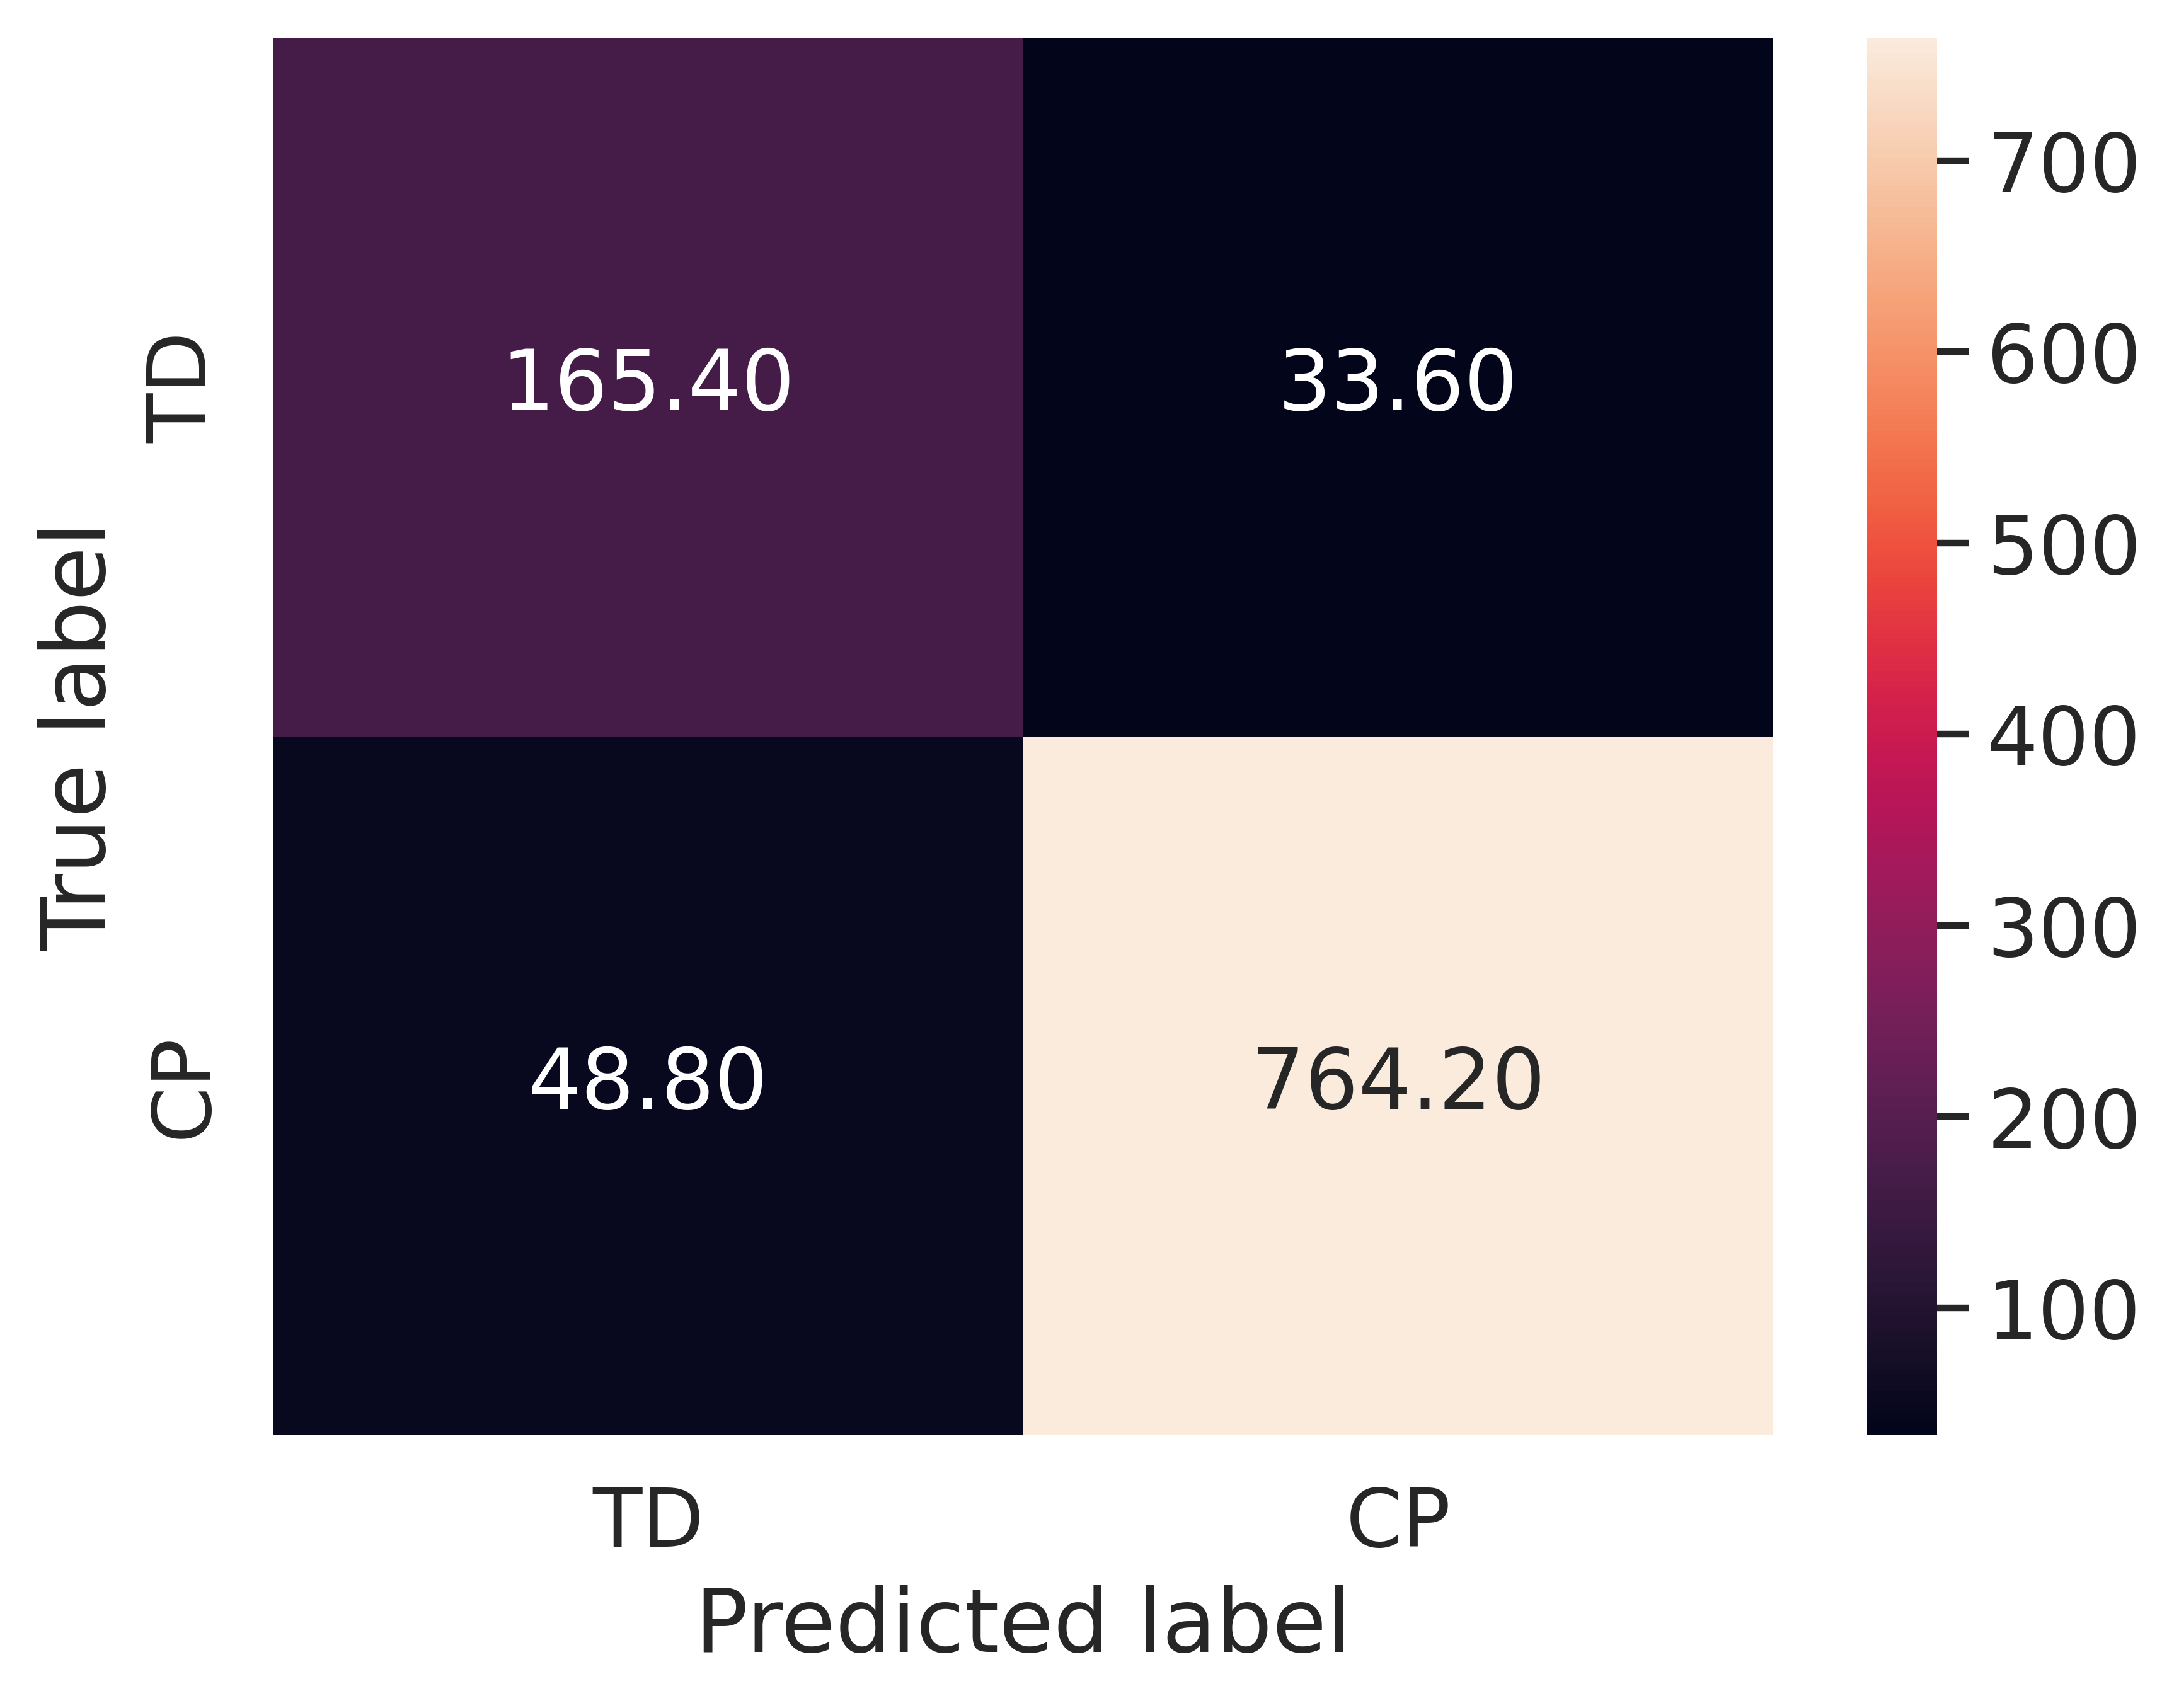

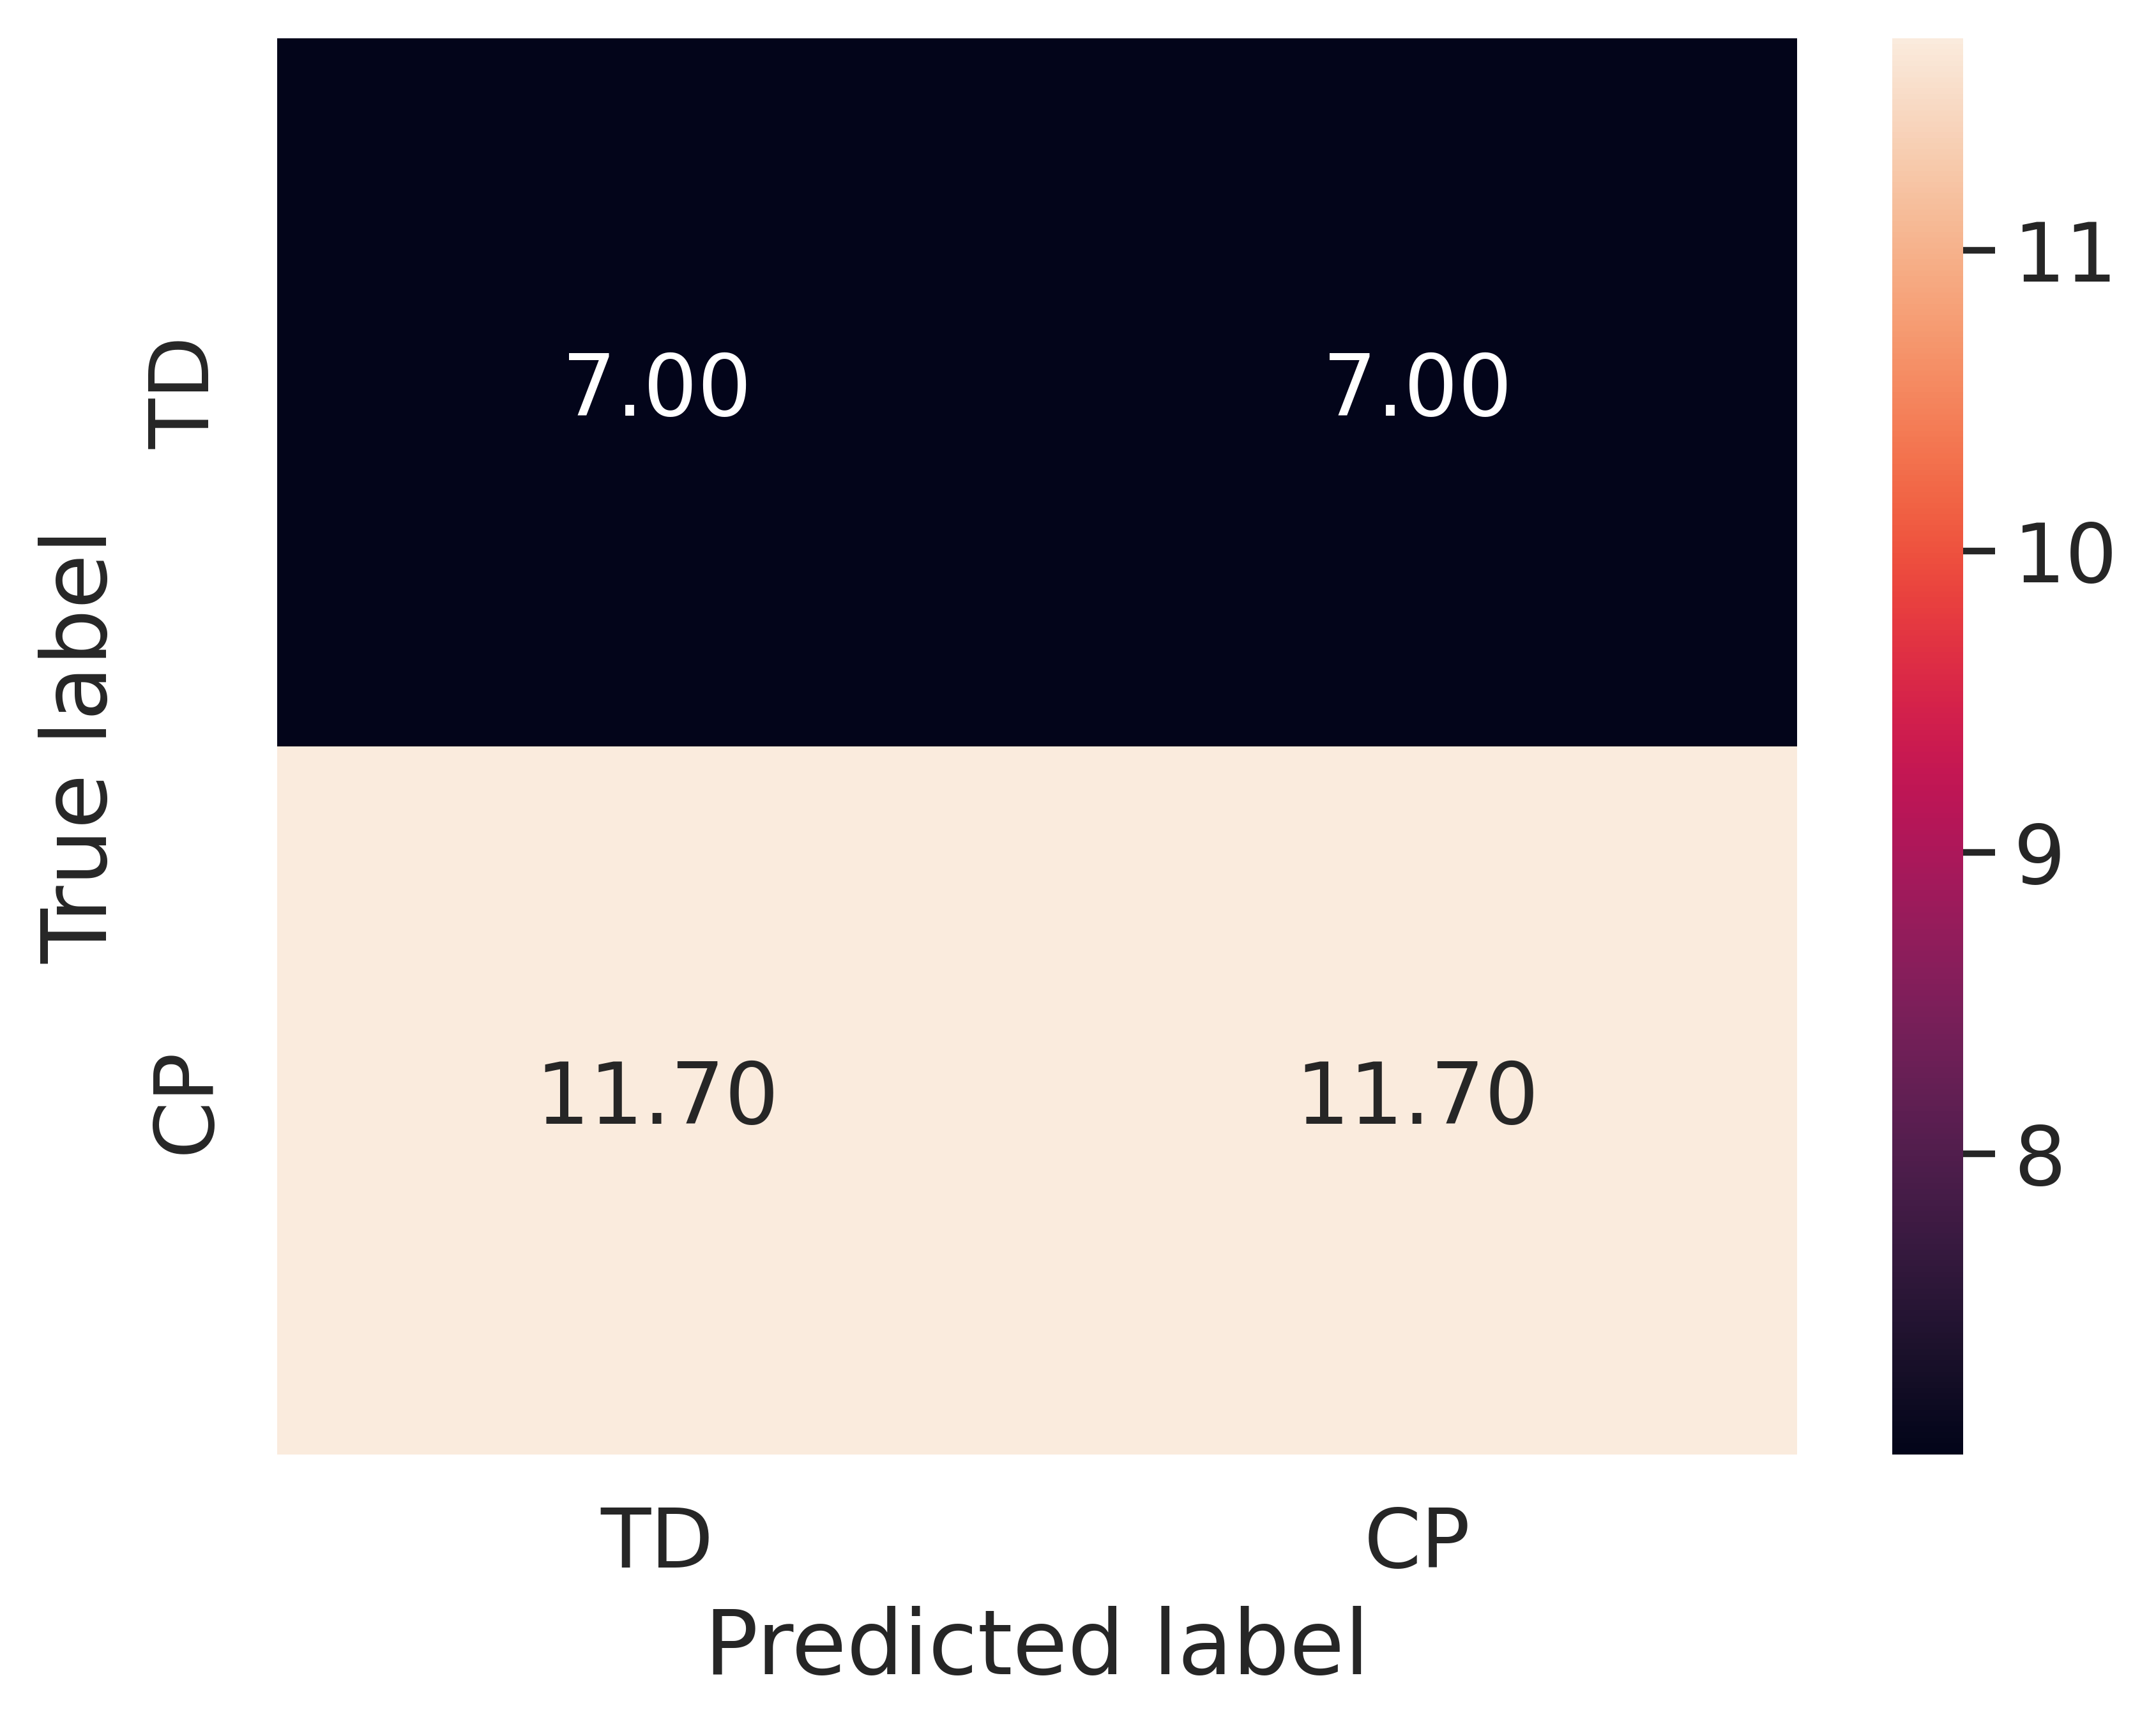

[[0.9185770750988143, 0.007073332082281915],
 [0.9399753997539977, 0.014394822965144188],
 [0.8311557788944723, 0.03519023396987255],
 [0.9488051911435411, 0.004840880380362715],
 [0.885565589324235, 0.01237554516086714]]

In [5]:
out = np.load( './new_train_lrR_ET_TDvsCPu_full_5_ResNet/prediction.npy')
print_result_bundle_i_cycles(out,y_d,x_test,cycle_end_idx,label_list=['TD', 'CP'],n_model=10)

## Load the evaluation results and evaluate the model by subjects. Plot the confusion matrix and std of confusion matrix 

(array([ 4, 16, 21, 31, 50]),)
(array([ 4, 21, 31, 55]),)
(array([ 4, 21, 31, 55]),)
(array([ 4, 16, 21, 31, 38, 55]),)
(array([ 4, 21, 38, 55]),)
(array([ 4, 21, 38, 55]),)
(array([ 4,  6, 21, 38, 55]),)
(array([ 4, 21, 38, 55]),)
(array([ 4, 21, 31, 38, 55]),)
(array([ 4, 16, 21, 31, 38, 55]),)
accuracy
[0.9206349206349206, 0.9365079365079365, 0.9365079365079365, 0.9047619047619048, 0.9365079365079365, 0.9365079365079365, 0.9206349206349206, 0.9365079365079365, 0.9206349206349206, 0.9047619047619048]
0.9253968253968254
0.012397221707788347
confusion matrix
[array([[14,  4],
       [ 1, 44]]), array([[16,  2],
       [ 2, 43]]), array([[16,  2],
       [ 2, 43]]), array([[15,  3],
       [ 3, 42]]), array([[17,  1],
       [ 3, 42]]), array([[17,  1],
       [ 3, 42]]), array([[17,  1],
       [ 4, 41]]), array([[17,  1],
       [ 3, 42]]), array([[16,  2],
       [ 3, 42]]), array([[15,  3],
       [ 3, 42]])]
[[16.   2. ]
 [ 2.7 42.3]]
[[1.         1.        ]
 [0.78102497 0.7810249

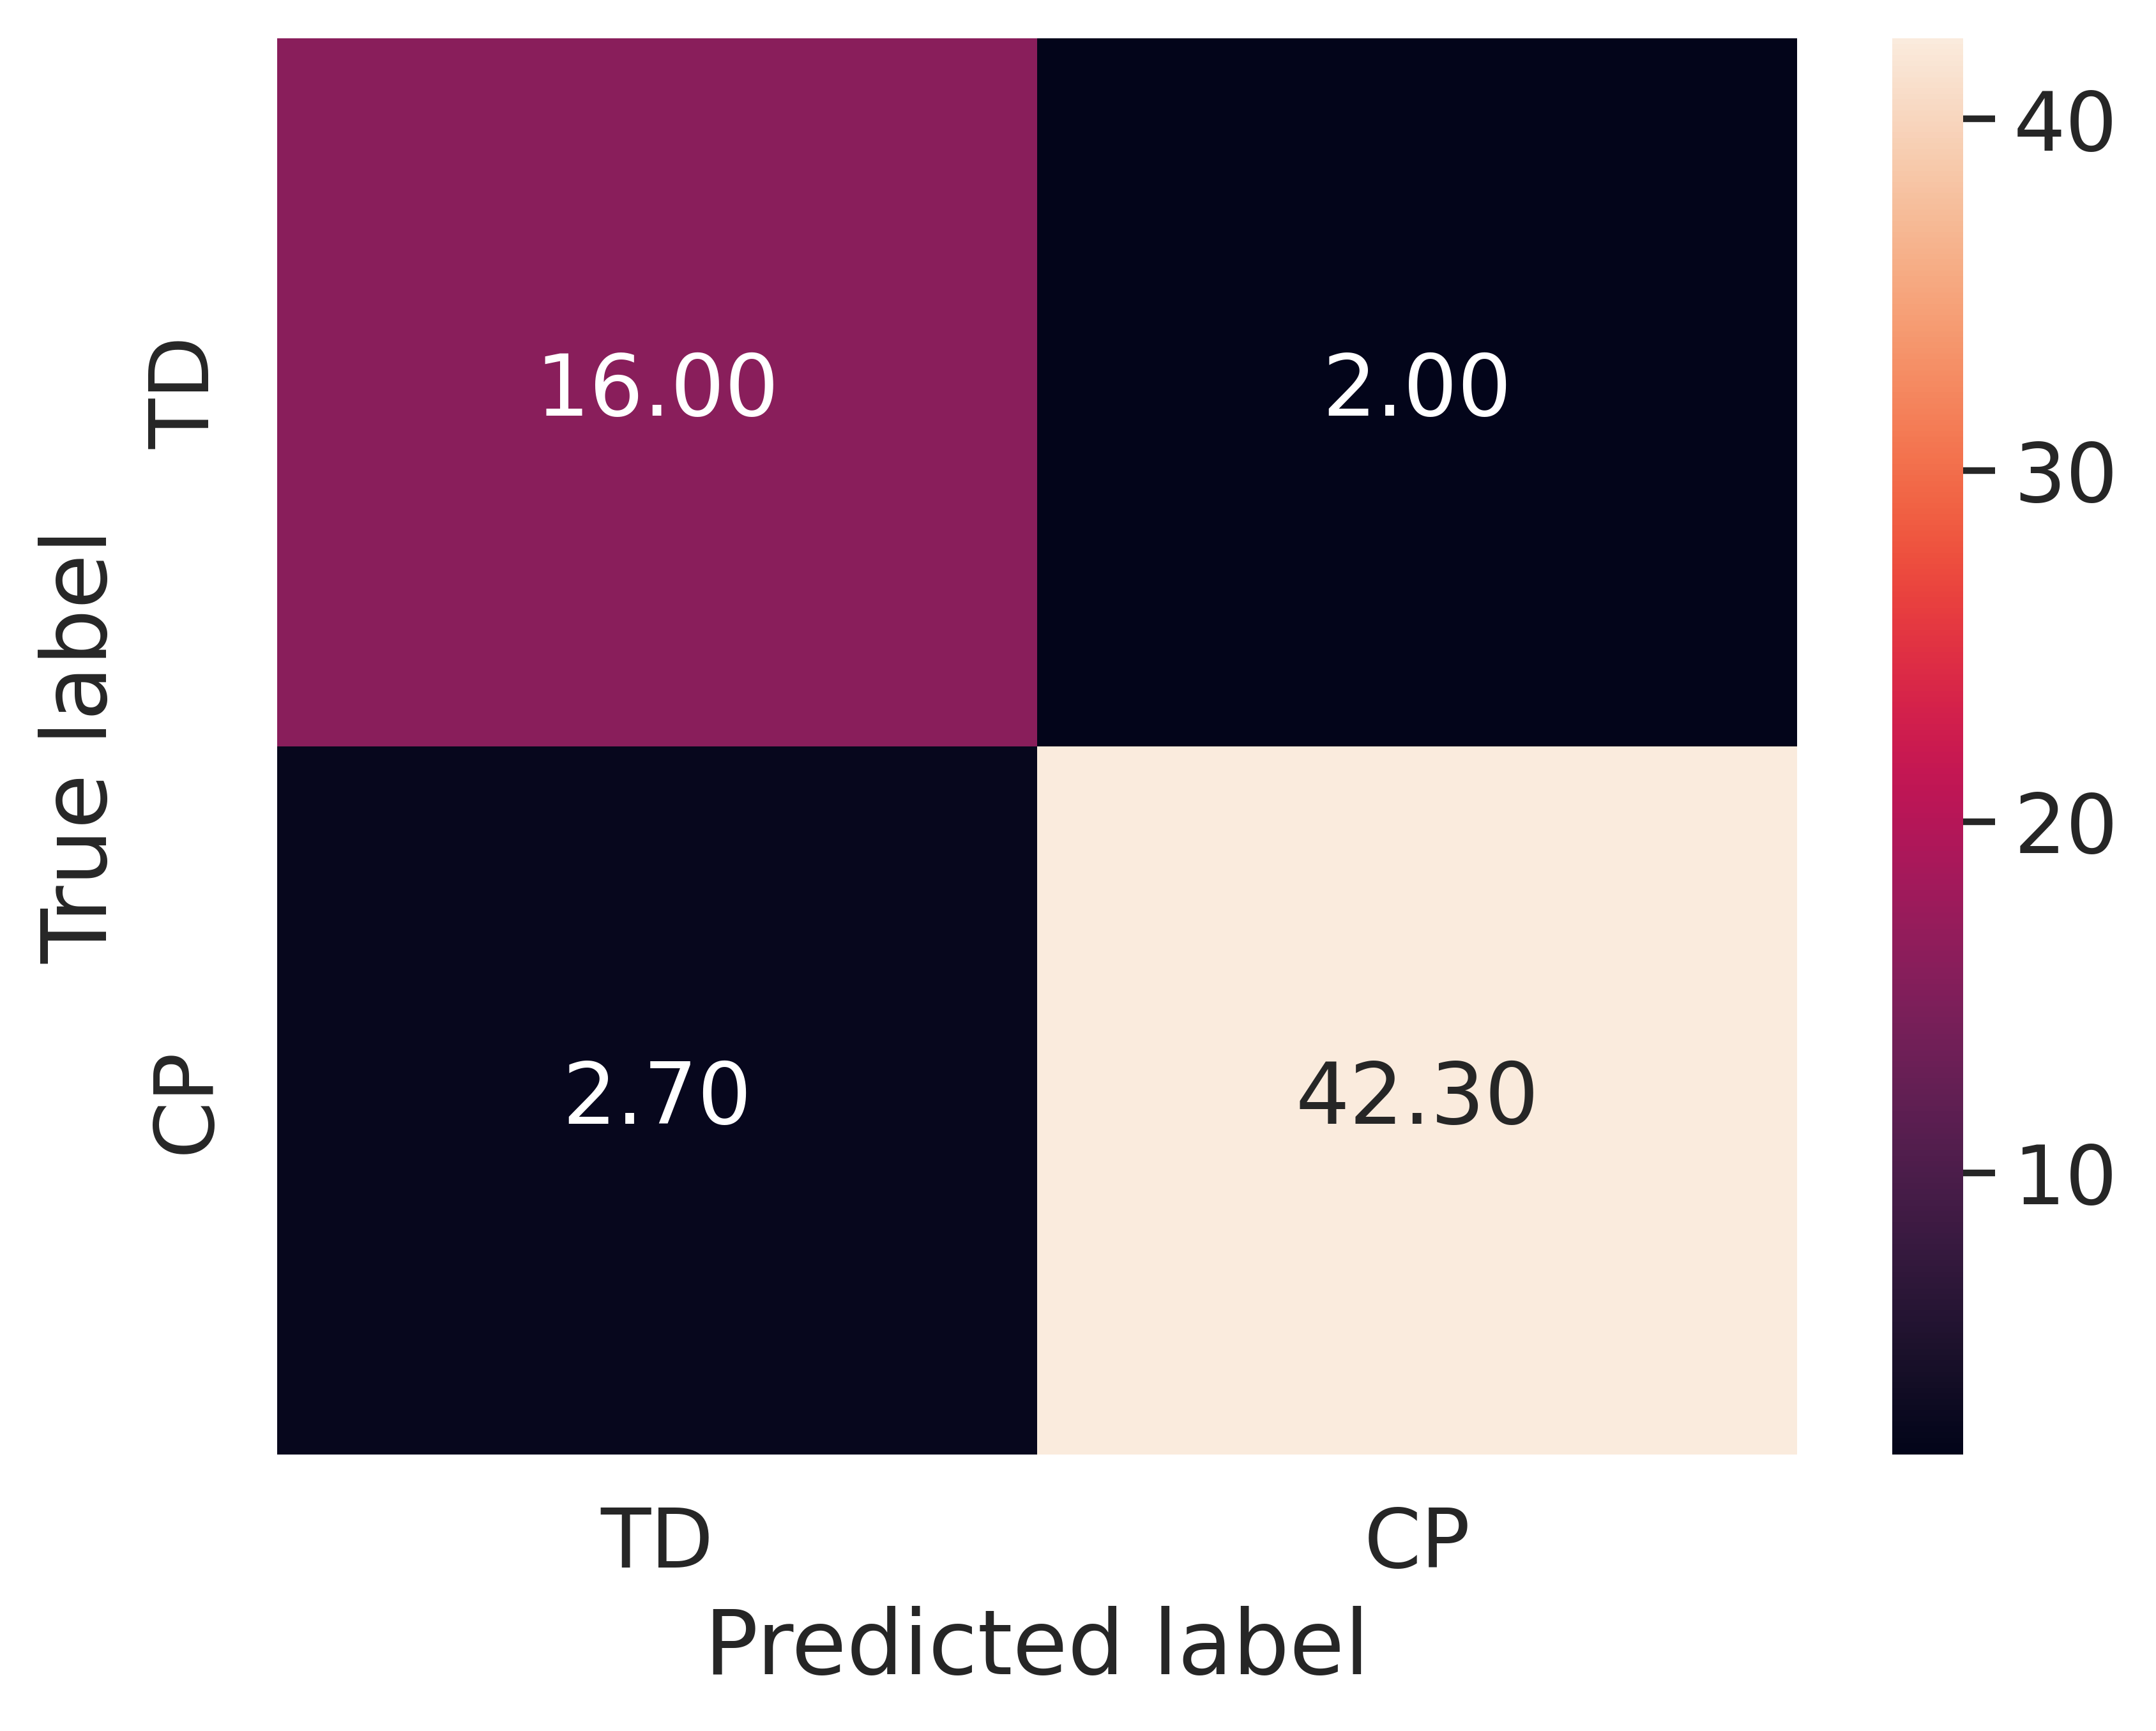

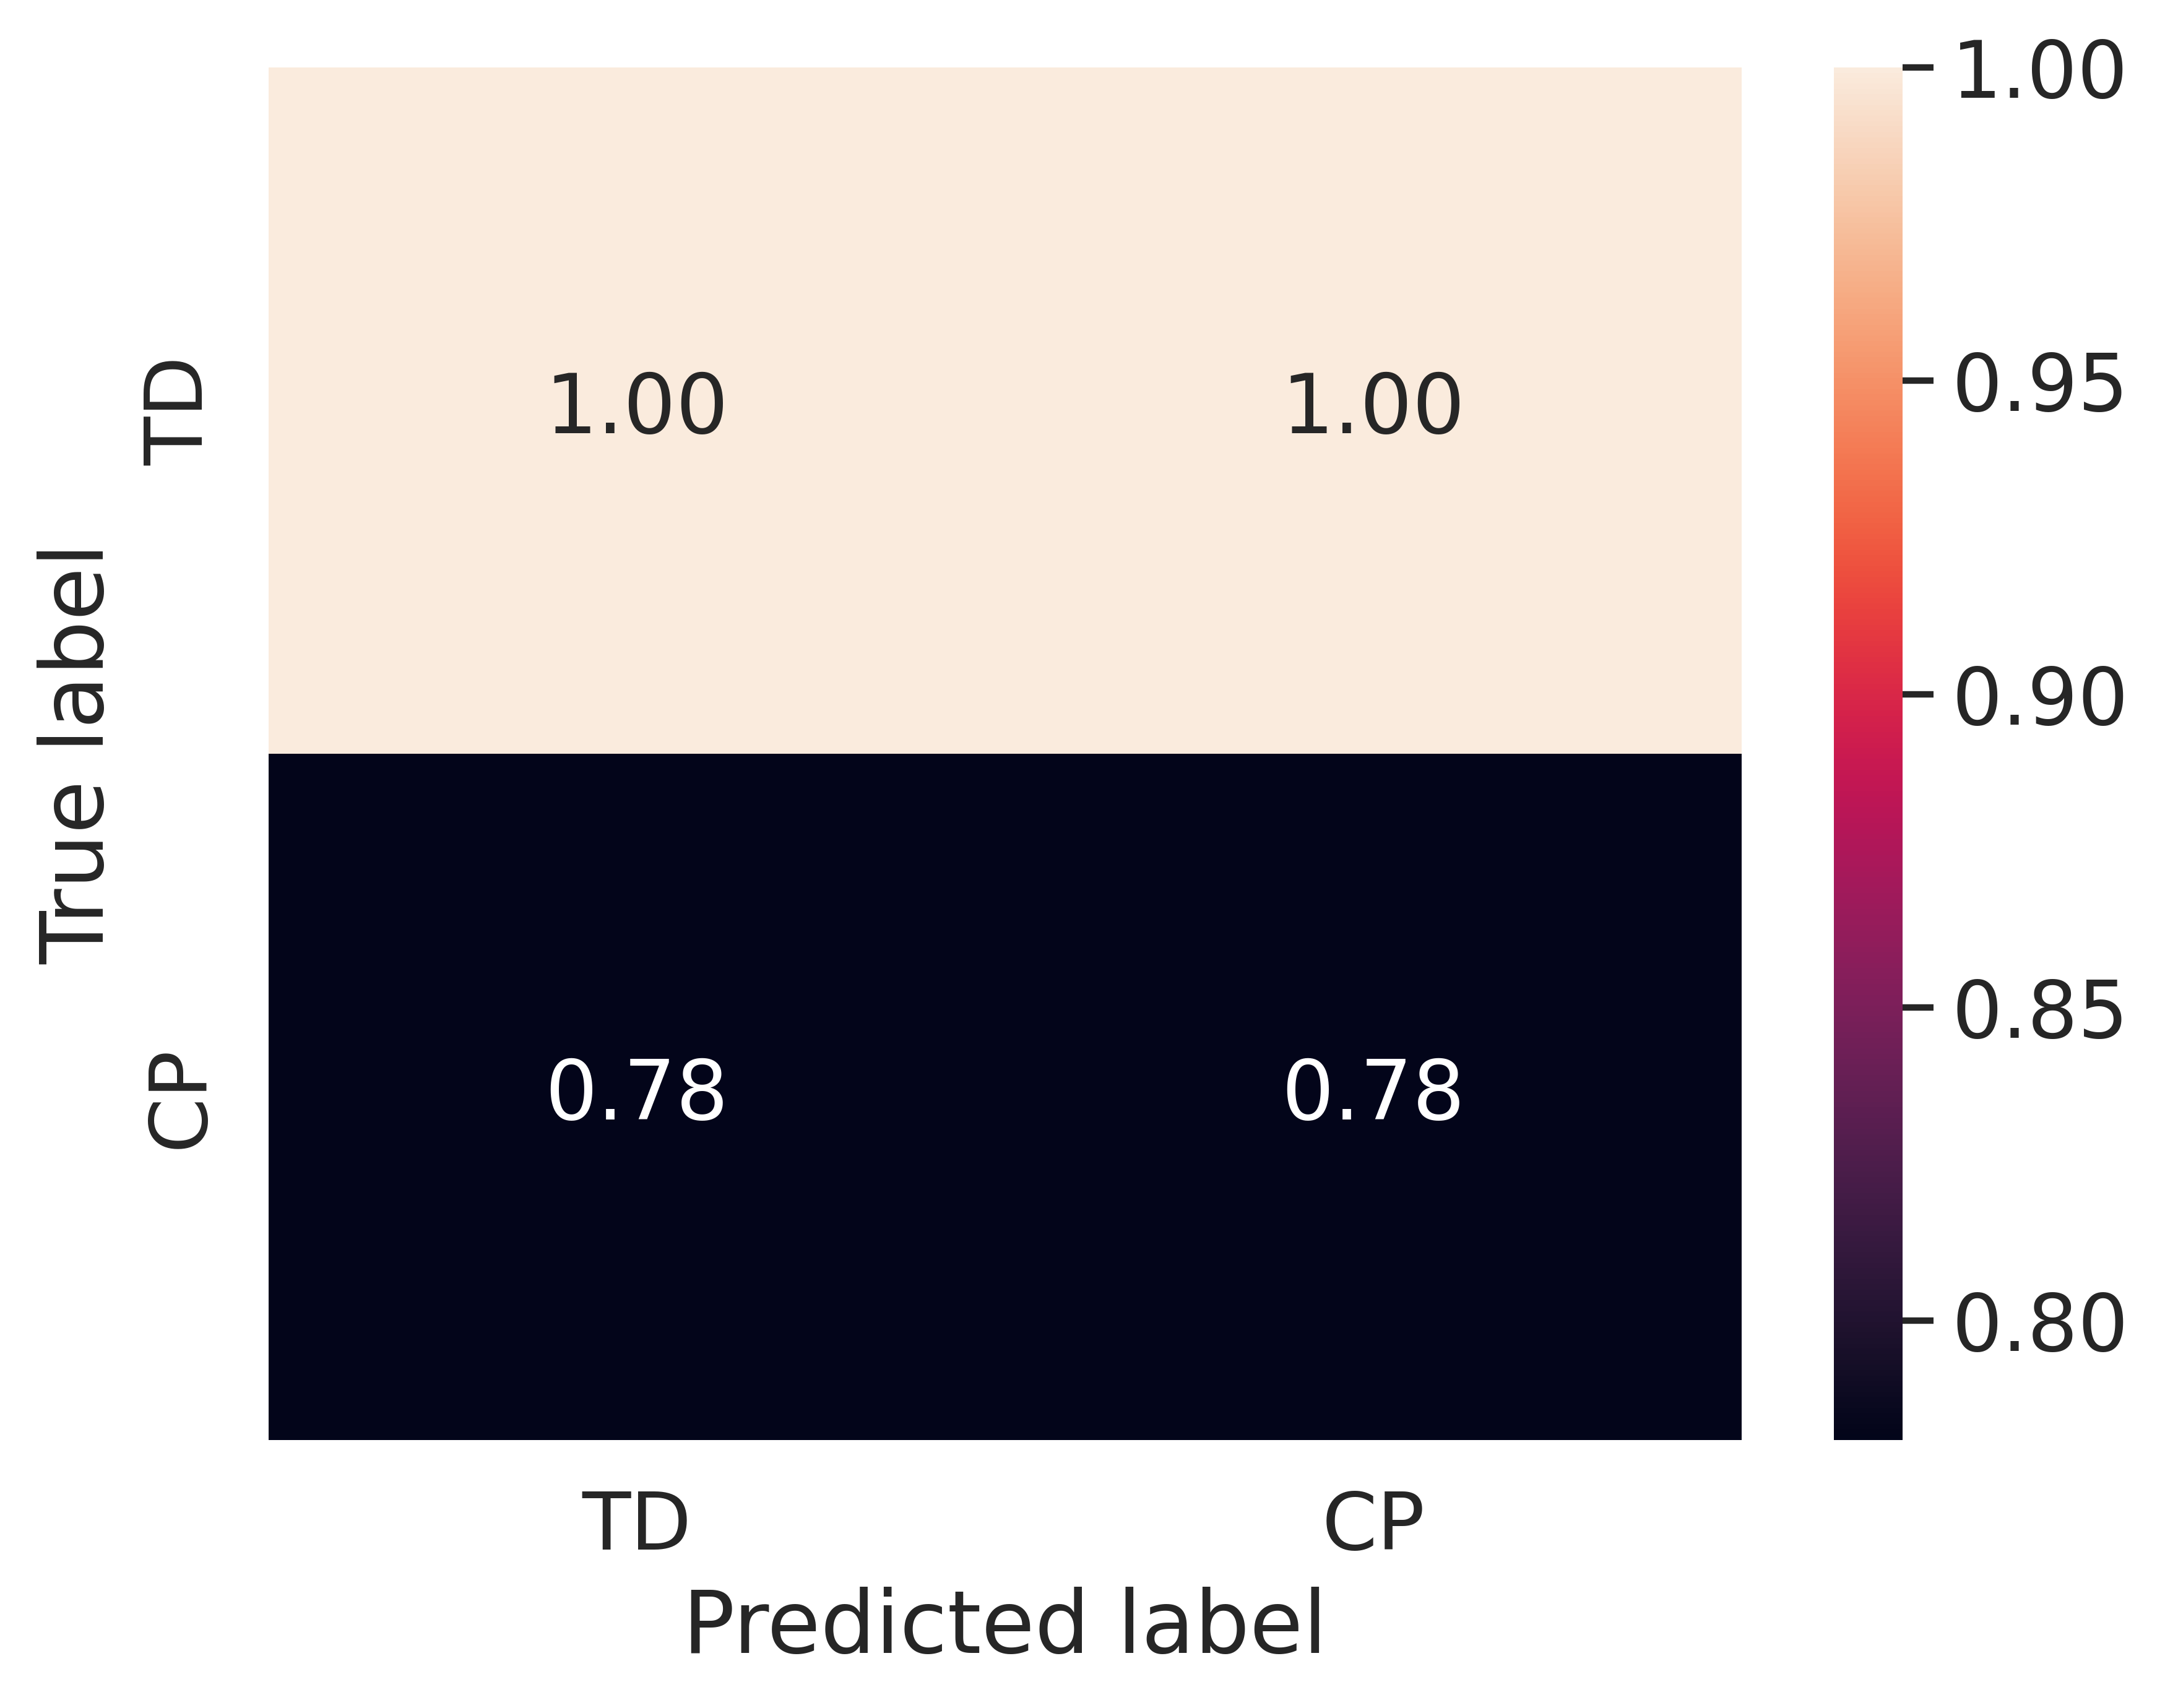

[[0.9253968253968254, 0.012397221707788347],
 [0.9400000000000001, 0.01735611039090368],
 [0.888888888888889, 0.05555555555555554],
 [0.9473999660905212, 0.008484330022292928],
 [0.9144444444444444, 0.02320068113091234]]

In [6]:
print_result_bundle_i_subjects(out,y_d,x_test, y_test,cycle_end_idx,label_list=['TD', 'CP'],n_model=10)